In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import math as m
import datetime
import timeit
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import random

In [2]:
def removered(t):
    torem = []
    for i in range(len(t) - 1):
        if ((t[i + 1][1] - t[i][1]).total_seconds()) <= 60:
            torem.append(i)
    return ([t[x] for x in range(len(t)) if x not in torem])


# Cost of deleting a point
def costdel(t, k, c):
    # Get all x, y, and time terms not in point
    x = np.array([t[i][2] for i in range(len(t)) if i != k])
    y = np.array([t[i][3] for i in range(len(t)) if i != k])
    ti = np.array([t[i][1] for i in range(len(t)) if i != k])
    n = len(t)

    # Calculate cost of displacement from deletion
    xpart = (((np.sum(x) + t[k][2]) / n) - (np.sum(x) / (n - 1))) ** 2
    ypart = (((np.sum(y) + t[k][3]) / n) - (np.sum(y) / (n - 1))) ** 2
    tpart = (((np.sum(ti) + t[k][1]) / n) - (np.sum(ti) / (n - 1))) ** 2
    cost = (1 - c) * (xpart + ypart) + c * (tpart)
    #     print("costdel xpart: ", xpart)
    #     print("costdel ypart: ", ypart)
    #     print("costdel tpart: ", tpart)
    #     print("costdel: ", cost)
    # Return cost
    return (m.sqrt(cost))

def preprop(df):
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["datetime"] = df["datetime"].apply(lambda v: v.timestamp())
    scaler = MinMaxScaler()
    df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
    return(df)

def costins(t, p, c):
    # Get all x, y, and time terms in the trajectory
    x = np.array([t[i][2] for i in range(len(t))])
    y = np.array([t[i][3] for i in range(len(t))])
    ti = np.array([t[i][1] for i in range(len(t))])
    n = len(t)

    # Calculate cost of insertion
    xpart = (((np.sum(x)) / n) - ((np.sum(x) + p[2]) / (n + 1))) ** 2
    ypart = ((np.sum(y) / n) - ((np.sum(y) + p[3]) / (n + 1))) ** 2
    tpart = ((np.sum(ti) / n) - ((np.sum(ti) + p[1]) / (n + 1))) ** 2
    cost = (1 - c) * (xpart + ypart) + c * (tpart)
    #     print("costins xpart: ", xpart)
    #     print("costins ypart: ", ypart)
    #     print("costins tpart: ", tpart)
    #     print("costins: ", cost)
    # Return cost
    return (m.sqrt(cost))


def costrep(t, k, p, c):
    # Get all x, y, and time terms not in point to be replaced
    x = np.array([t[i][2] for i in range(len(t)) if i != k])
    y = np.array([t[i][3] for i in range(len(t)) if i != k])
    ti = np.array([t[i][1] for i in range(len(t)) if i != k])
    n = len(t)

    # Calculate cost of displacement from replacement
    xpart = (((np.sum(x) + t[k][2]) / n) - ((np.sum(x) + p[2]) / n)) ** 2
    ypart = (((np.sum(y) + t[k][3]) / n) - ((np.sum(y) + p[3]) / n)) ** 2
    tpart = (((np.sum(ti) + t[k][1]) / n) - ((np.sum(ti) + p[1]) / n)) ** 2
    cost = (1 - c) * (xpart + ypart) + (c * tpart)
    #     print("costrep xpart: ", xpart)
    #     print("costrep ypart: ", ypart)
    #     print("costrep tpart: ", tpart)
    #     print("costrep: ", cost)
    # Return cost
    return (m.sqrt(cost))


# t's are formatted as [[id,x,y,time],[id,x,y,time],....] where time is pandas datetime
def editdist(t1, t2, c):
    # Revised trajectories
    # t1 = removered(t1)
    # t2 = removered(t2)

    # Get trajectory lengths
    n1 = len(t1)
    n2 = len(t2)
    #     print("n1: ", n1)
    #     print("n2: ", n2)

    # Create table to save prior solutions
    table = [[0 for i in range(n2 + 1)] for j in range(n1 + 1)]

    # Note, should t1 be updated before calculating cost of next insert/del?
    # Fill in table where i represents number of points in t1 and j the number of points in t2
    for i in range(n1 + 1):
        for j in range(n2 + 1):

            # Fill first row of table
            if i == 0:
                table[i][j] = sum([costins(t1, p, c) for p in t2[:j]])
            #                 print("table value with i = " +str(i) + "and j = " + str(j) + " : ", table[i][j])
            # Fill first column of table
            elif j == 0:
                table[i][j] = sum([costdel(t1, k, c) for k in range(i)])
            #                 print("table value with i = " +str(i) + "and j = " + str(j) + " : ", table[i][j])

            # Keep cost the same if points are the same
            elif t1[i - 1].all == t2[j - 1].all:
                table[i][j] = table[i - 1][j - 1]
            #                 print("table value with i = " +str(i) + "and j = " + str(j) + " : ", table[i][j])

            # Calculate whether insertion, deletion, or replacement costs the most, and save whichever one is least expensive
            else:
                valins = table[i][j - 1] + costins(t1, t2[j - 1], c)
                valdel = table[i - 1][j] + costdel(t1, i - 1, c)
                valrep = table[i - 1][j - 1] + costrep(t1, i - 1, t2[j - 1], c)
                #                 print("valins: ", valins)
                #                 print("valdel: ", valdel)
                #                 print("valrep: ", valrep)

                if (valins <= valdel) and (valins <= valrep):
                    table[i][j] = valins
                #                     print("valins in if: ", valins)
                #                     print("table value with i = " +str(i) + "and j = " + str(j) + " : ", table[i][j])

                elif (valdel <= valins) and (valdel <= valrep):
                    table[i][j] = valdel
                #                     print("valdel in if: ", valdel)
                #                     print("table value with i = " +str(i) + "and j = " + str(j) + " : ", table[i][j])

                elif (valrep <= valdel) and (valrep <= valins):
                    table[i][j] = valrep
    #                     print("valrep in if: ", valrep)
    #                     print("table value with i = " +str(i) + "and j = " + str(j) + " : ", table[i][j])

    return table[n1][n2]

In [17]:
def createtraj(data, size):
    unpro = data.drop(["taxiid", "datetime"], axis = 1)
    unpro = unpro.values.tolist()
    preprodata = preprop(data)
    preprodata = preprodata.values.tolist()
    i = 0
    n = len(data)
    preprotraj = []
    traj =[]
    while i + size < n:
        #print(data.iloc[i:i+size,:])
        traj.append(unpro[i:i+size])
        preprotraj.append(preprodata[i:i+size])
        i += size
    return (np.asarray(preprotraj), np.asarray(traj))

def createtraj2(data):
    unpro = data.drop(["taxiid", "datetime"], axis = 1)
    unpro = unpro.values.tolist()
    preprodata = preprop(data)
    preprodata = preprodata.values.tolist()
    i = 0
    n = len(data)
    preprotraj = []
    traj =[]
    for i in range(n):
        #print(data.iloc[i:i+size,:])
        traj.append(unpro[i:i+1])
        preprotraj.append(preprodata[i:i+1])
        i += 1
    return (np.asarray(preprotraj), np.asarray(traj))

# Main clustering algorithm
def tcluster(lines, eps, minlns, c):
    # Create array to hold cluster values
    Cluster = np.zeros(len(lines))
    # Set fist cluster to one
    cid = 1
    # For each trajectory
    for i in range(len(lines)):
        line = lines[i]

        # if the trajectory is unclassified, classify it or designate it as noise
        if Cluster[i] == 0:
            # Get neighbors of a trajectory
            N = neighbor(line, eps, lines, c)
            # Check if trajectory has minimum number of neighbors
            if (len(N) >= minlns):
                # Give neighbors the cluster id
                for n in N:
                    Cluster[n] = cid
                queue = [n for n in N if n != i]
                # Expand cluster based on neighbors of neighbor
                Cluster = expandcluster(queue, cid, eps, minlns, Cluster, lines, c)
                # Move to next cluster
                cid += 1
            # If line is unclassified and without enough neighbors to be it's own cluster designate it as noise
            else:
                Cluster[i] = -1
    # Return list of cluster designations, with indices corresponding to trajectories' indices in lines array
    return Cluster


# Expland cluster based on neighbors of neighbor
def expandcluster(Q, cid, eps, minlns, Cluster, lines, c):
    while len(Q) != 0:
        M = Q.pop(0)
        line = lines[M]
        N = neighbor(line, eps, lines, c)
        if (len(N) >= minlns):
            for n in N:
                if Cluster[n] in [0, -1]:
                    if Cluster[n] == 0:
                        Q.append(n)
                    Cluster[n] = cid
        return Cluster


# Get trajectory neighbor
def neighbor(trajectory, eps, lines, c):
    distances = np.asarray([editdist(trajectory, t, c) for t in lines])
    neighbor_indices = np.where(distances <= eps)[0]
    return neighbor_indices

In [4]:
data = pd.read_csv("/Users/tabithasugumar/Documents/Capstone/Data/Data/AllTaxi.csv")

In [5]:
taxi2s = data.sample(n = 10000) #taxitest = data[(data.taxiid == 8711)|(data.taxiid == 3644)]

In [27]:
clust, vis = (createtraj(taxi2s, 4))
len(clust)

2499

In [28]:
times = []
for i in range(0,550,50):
    ct = clust[np.random.choice(clust.shape[0], i, replace=False), :]
    print(i)
    start = time.time()
    tcluster(ct, 0.015, 10, 0.5)
    end = time.time()
    times.append(end - start)

0
50
100
150
200
250
300
350
400
450
500


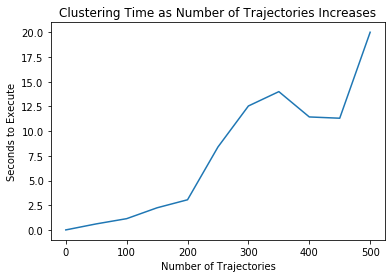

In [29]:
x = [i for i in range(0,550,50)]
plt.plot(x,times)
plt.xlabel("Number of Trajectories")
plt.ylabel("Seconds to Execute")
plt.title("Clustering Time as Number of Trajectories Increases")
plt.show()

In [30]:
print(times)

[2.5033950805664062e-05, 0.6093831062316895, 1.1395699977874756, 2.2409889698028564, 3.0525429248809814, 8.39923906326294, 12.548947811126709, 14.001224994659424, 11.438684940338135, 11.308794975280762, 20.014174938201904]


In [31]:
times = []
x = [2,3,4,5,10,20]
for i in x:
    clust, vis = (createtraj(taxi2s, i))
    ct = clust[np.random.choice(clust.shape[0], 300, replace=False), :]
    print(i)
    start = time.time()
    tcluster(ct, 0.015, 20, 0.5)
    end = time.time()
    times.append(end - start)

2
3
4
5
10
20


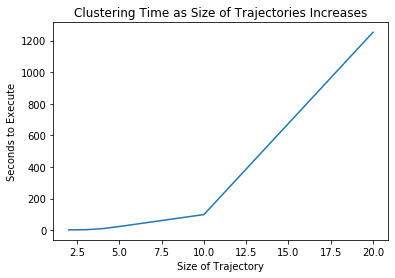

In [32]:
x = [2,3,4,5,10,20]
plt.plot(x,times)
plt.xlabel("Size of Trajectory")
plt.ylabel("Seconds to Execute")
plt.title("Clustering Time as Size of Trajectories Increases")
plt.show()

In [33]:
print(times)

[1.4711709022521973, 2.7845020294189453, 9.435696125030518, 23.129806995391846, 98.69934797286987, 1253.0512919425964]


In [20]:
clust,vis = createtraj2(taxi2s)

In [24]:
times = []
for i in range(0,550,50):
    ct = clust[np.random.choice(clust.shape[0], i, replace=False), :]
    start = time.time()
    tcluster(ct, 0.015, 10, 0.5)
    end = time.time()
    times.append(end - start)

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


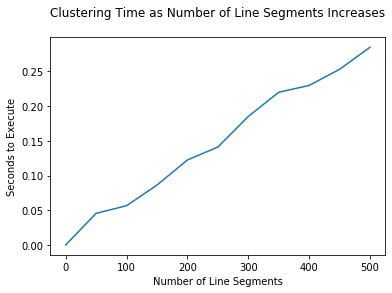

In [25]:
x = [i for i in range(0,550,50)]
plt.plot(x,times)
plt.xlabel("Number of Line Segments")
plt.ylabel("Seconds to Execute")
plt.title("Clustering Time as Number of Line Segments Increases\n")
plt.show()

In [26]:
print(times)

[8.106231689453125e-06, 0.04546928405761719, 0.05654501914978027, 0.08622598648071289, 0.12239480018615723, 0.14104318618774414, 0.18517088890075684, 0.22001910209655762, 0.22978997230529785, 0.2531001567840576, 0.28486108779907227]
